In [107]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List
from astropy.table import Table
from astropy.io import ascii

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

In [108]:
RA: float = 11.7980
DEC: float = 85.2440
    
COLUMNS: List[str] = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
MIN_PARALLAX: float = 0.25
MAX_PARALLAX: float = 0.75
    
CLUSTER_NAME: str = 'NGC 188'
DEGREES: int = 1

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [109]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/1_deg.csv', index_col=None)

In [110]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 2300138708529315712,2300138708529315712,662381376,2016.0,359.985190,0.082591,85.152716,0.076308,0.230850,...,0.0162,0.0037,0.0413,0.0129,0.0029,0.033,0.0070,0.0016,0.0180,PHOENIX
1,1636148068921376768,Gaia DR3 2300141663466822400,2300141663466822400,1219913963,2016.0,359.864403,0.184853,85.159847,0.178241,0.214223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636148068921376768,Gaia DR3 2300141667762951680,2300141667762951680,675368024,2016.0,359.912261,2.632776,85.157557,1.803413,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1636148068921376768,Gaia DR3 2300141938344743680,2300141938344743680,905723877,2016.0,359.893132,0.126966,85.175524,0.126572,0.401293,...,0.0116,0.0029,0.0301,0.0085,0.0021,0.022,0.0046,0.0011,0.0118,PHOENIX
4,1636148068921376768,Gaia DR3 2300142007064237952,2300142007064237952,365479039,2016.0,359.844342,0.623943,85.192913,0.546537,-0.602586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


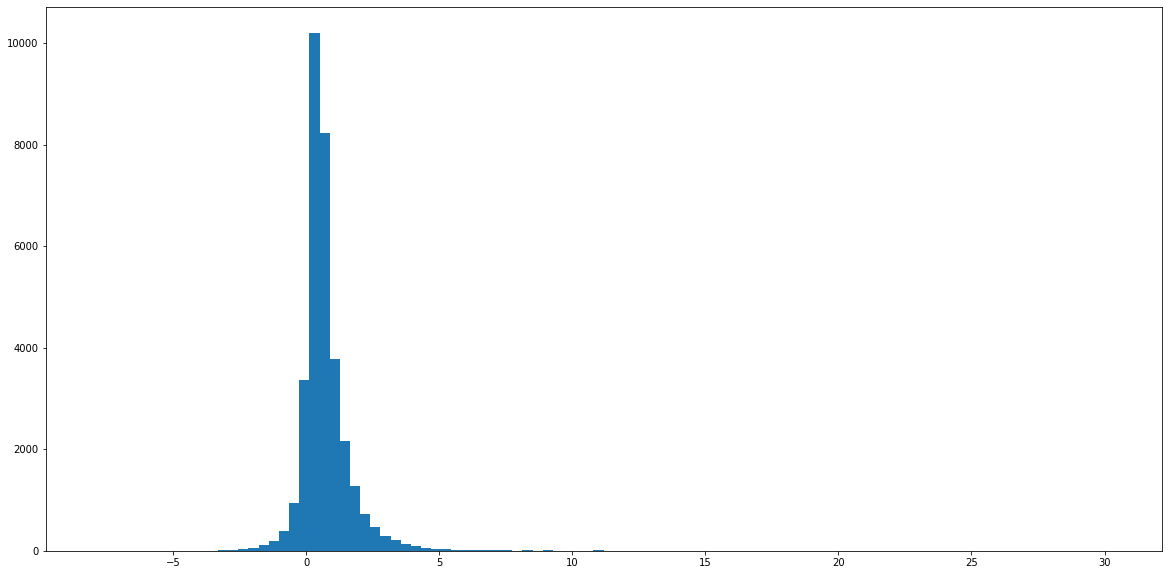

In [111]:
plt.figure(figsize=(20, 10))
plt.hist(sources.parallax, bins=100);

# Preprocessing

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [112]:
def filter_by_parallax(sources: pd.DataFrame,
                       min_parallax: float,
                       max_parallax: float) -> pd.DataFrame:
    sources_par = sources[(sources['parallax']>min_parallax) & (sources['parallax']<max_parallax)]
    print(f'After parallax filtering: {len(sources_par)}')
    return sources_par

def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def normalize(sources: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    scaler = StandardScaler()
    return scaler.fit_transform(sources[columns])

def prepare_data_for_clustering(sources: pd.DataFrame,
                                min_parallax: float,
                                max_parallax: float,
                                columns: List[str]) -> pd.DataFrame:
    return wrap_coordinates(
        clean_nans(
            filter_by_parallax(sources, min_parallax, max_parallax),
            columns
        )
    )

In [113]:
sources_to_cluster = prepare_data_for_clustering(sources, MIN_PARALLAX, MAX_PARALLAX, COLUMNS)
sources_normalized = normalize(sources_to_cluster, COLUMNS)

After parallax filtering: 13684
After dropping NaNs from ['ra', 'dec', 'parallax', 'pmra', 'pmdec']: 13684


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Normalization scales the features to an unit variance.

In [114]:
def plot_on_aitoff(sources: pd.DataFrame, cluster_name: str, degrees: float):
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources.ra,
                                          dec=sources.dec,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    plt.figure(figsize=(10, 7));
    plt.subplot(111, projection="aitoff");
    plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon',
                label=f'{cluster_name} center$\pm {degrees}^\circ$');
    plt.grid();
    plt.legend(loc='lower right', fontsize=14);

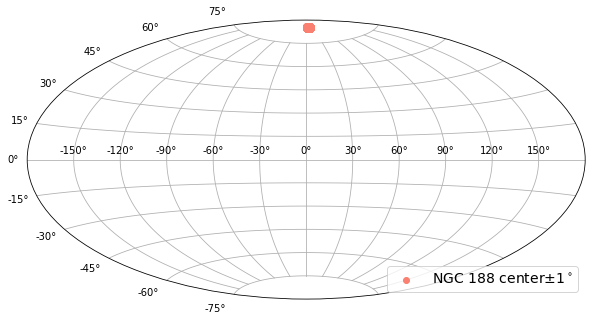

In [115]:
plot_on_aitoff(sources_to_cluster, CLUSTER_NAME, DEGREES)

# DBSCAN

In [116]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=20)
    dbscan_fit = dbscan_clust.fit(sources_normalized)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels: {unique_labels}')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

In [117]:
cluster_children: pd.DataFrame = fetch_object_children('NGC 188')

In [118]:
cluster_children.head()

,obj_id,link_bibcode,ra,dec
0,NGC 188 1054,2004PASP..116.1012S,11.191250,85.256734
1,Cl* NGC 188 DGV 1869,2004PASP..116.1012S,9.743203,85.559916
2,NGC 188 2014,2004PASP..116.1012S,10.977598,85.205113
3,NGC 188 1152,2004PASP..116.1012S,11.164145,85.242850
4,NGC 188 3129,2004PASP..116.1012S,11.151445,85.352770


In [119]:
def is_in_cluster(source: np.array, cluster_coords: np.array) -> bool:
    return (np.any(np.isclose(source[0], cluster_coords[:, 0].astype(np.float32), rtol=1e-4)) and
            np.any(np.isclose(source[1], cluster_coords[:, 1].astype(np.float32), rtol=1e-4)))

In [120]:
def check_for_cluster_children(cluster_children: pd.DataFrame,
                               sources_cluster: pd.DataFrame) -> bool:
    cluster_children_coords = np.unique(cluster_children.values[:, [2, 3]].astype(float), axis=0)
    sources_coords = sources_cluster[['ra', 'dec']].values
    
    in_cluster = np.array(list(map(lambda x: is_in_cluster(x, sources_coords), cluster_children_coords)))
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return len(trues)/len(in_cluster)

def check_for_undiscovered_sources(cluster_children: pd.DataFrame,
                                   sources_cluster: pd.DataFrame) -> bool:
    cluster_children_coords = np.unique(cluster_children.values[:, [2, 3]].astype(float), axis=0)
    sources_coords = sources_cluster[['ra', 'dec']].values
    
    in_cluster = np.array(list(map(lambda x: is_in_cluster(x, cluster_children_coords), sources_coords)))
    falses = in_cluster[~in_cluster]
    print(f'Found {len(falses)} objects found in the cluster unreported in papers.')
    return len(falses)

In [190]:
def cross_match_function(clustered: pd.DataFrame):
    
    clustered_coordinates = clustered[['ra', 'dec']].values
    
    def cross_match_index(ra: float, dec: float,
                          threshold: float = 1e-3) -> int:

        diffs = np.max(np.abs(clustered_coordinates-np.array([ra, dec])),axis=1)
        ind = np.argmin(diffs)
        difference = diffs[ind]

        if difference < threshold:
            return ind
        else:
            return -1
        
    return cross_match_index

In [191]:
cm_fun = cross_match_function(clustered)

In [192]:
literature_indices = np.vectorize(cm_fun)(cluster_children.ra.values, cluster_children.dec.values)

In [196]:
cluster_children['gaia_ind'] = literature_indices

In [198]:
ns_fun = cross_match_function(noise)
literature_noise_indices = np.vectorize(ns_fun)(cluster_children.ra.values, cluster_children.dec.values)

In [199]:
cluster_children['noise_ind'] = literature_noise_indices

In [200]:
unclustered = cluster_children[cluster_children['gaia_ind']==-1]

In [205]:
unclustered.noise_ind

36        -1
777       -1
824       -1
834       -1
848       -1
        ... 
4200      -1
4203      -1
4208      -1
4327    9667
4335    9479
Name: noise_ind, Length: 472, dtype: int64

In [121]:
labels = dbscan(sources_normalized, eps=0.455)
labelled_sources = label_sources(sources_to_cluster, labels)
clustered, noise = get_clustered_and_noise(labelled_sources, labels)

r = check_for_cluster_children(cluster_children, clustered)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered)

Classified into 10 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
Clustered: 1570/13684
1307/1624 objects found in the cluster.
Found 229 objects found in the cluster unreported in papers.


In [122]:
def cluster_plot(clustered_sources: pd.DataFrame,
                 noise_sources: pd.DataFrame,
                 paper_sources: pd.DataFrame):
    plt.figure(figsize=(20, 10))
    plt.scatter(clustered_sources.ra, clustered_sources.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
    plt.scatter(noise_sources.ra, noise_sources.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
    plt.scatter(paper_sources.ra, paper_sources.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
    lgnd = plt.legend(fontsize=14);
    plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
    plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

    for handle in lgnd.legendHandles:
        handle._sizes = [30];

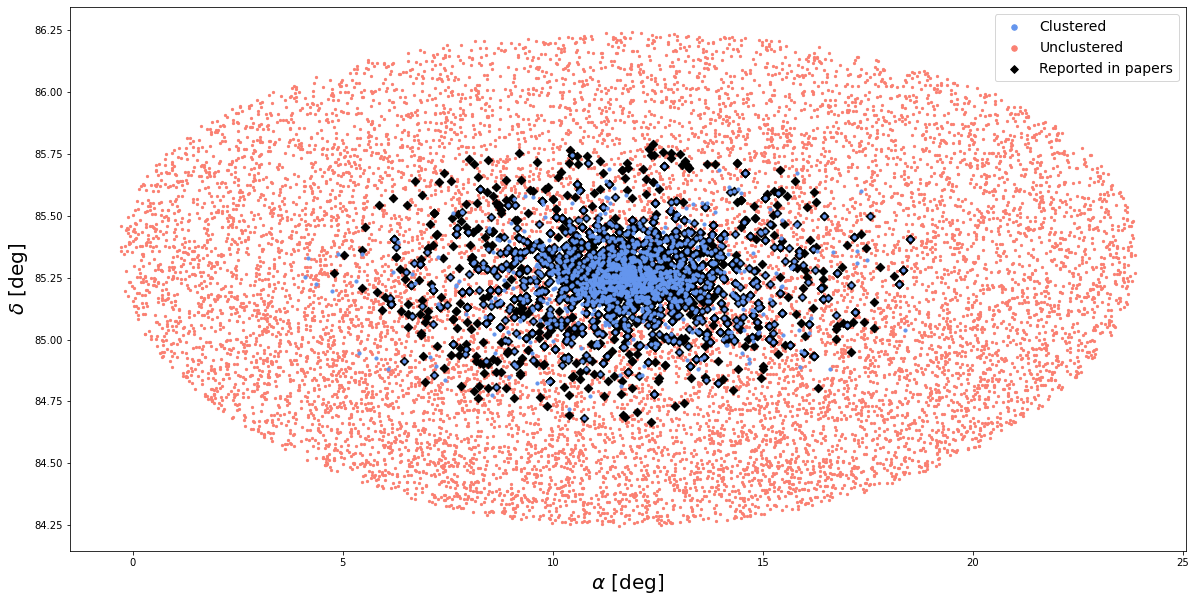

In [123]:
cluster_plot(clustered, noise, cluster_children)

In [128]:
cluster_children.head()

,obj_id,link_bibcode,ra,dec
0,NGC 188 1054,2004PASP..116.1012S,11.191250,85.256734
1,Cl* NGC 188 DGV 1869,2004PASP..116.1012S,9.743203,85.559916
2,NGC 188 2014,2004PASP..116.1012S,10.977598,85.205113
3,NGC 188 1152,2004PASP..116.1012S,11.164145,85.242850
4,NGC 188 3129,2004PASP..116.1012S,11.151445,85.352770


AttributeError: 'DataFrame' object has no attribute 'parallax'

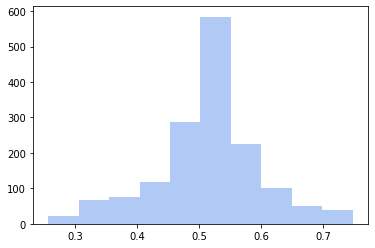

In [127]:
plt.hist(clustered.parallax, color='cornflowerblue', alpha=.5)
plt.hist(cluster_children.parallax, color='mediumvioletred', alpha=.5)

## HR diagram

In [103]:
def absolute_magnitude(g_mean_mag: np.float32,
                       g_ext: np.float32,
                       parallax: np.float32) -> np.float32:
    return g_mean_mag+5*np.log10(parallax)-10-g_ext

clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
# clustered['extinction_coefficient'] = extinction_coefficient(clustered.ra.values,
#                                                              clustered.dec.values,
#                                                              1/clustered.parallax.values)
# clustered['g_ext'] = gaia_g_extinction(clustered.extinction_coefficient.values)
# clustered['reddening'] = gaia_extinction(clustered.extinction_coefficient.values)
clustered['absolute_magnitude'] = absolute_magnitude(clustered.phot_g_mean_mag,
                                                     clustered.g_ext,
                                                     clustered.parallax.values.astype(np.float32))


/tmp/ipykernel_44530/2449140180.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
/tmp/ipykernel_44530/2449140180.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['absolute_magnitude'] = absolute_magnitude(clustered.phot_g_mean_mag,


(array([  5.,   8.,  37.,  53., 372., 358., 522., 178.,  23.,  14.]),
 array([0.2116997 , 0.2325075 , 0.2533153 , 0.2741231 , 0.2949309 ,
        0.31573874, 0.33654654, 0.35735434, 0.37816215, 0.39896995,
        0.41977775], dtype=float32),
 <BarContainer object of 10 artists>)

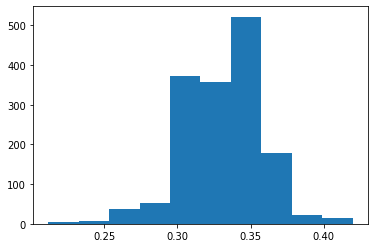

In [104]:
plt.hist(clustered.reddening)

In [105]:
def plot_hr(sources: pd.DataFrame):
    plt.figure(figsize=(10, 10))
    plt.scatter(sources.color, sources.absolute_magnitude,
                s=10., color='royalblue', marker='*', alpha=.5)
#     plt.scatter(sources.color-sources.reddening, sources.absolute_magnitude,
#                 s=10., color='mediumvioletred', marker='*', alpha=.5)
    plt.gca().invert_yaxis()
    plt.gca().set_xlabel('B-R [mag]', fontsize=14);
    plt.gca().set_ylabel('absolute magnitude [mag]', fontsize=14);

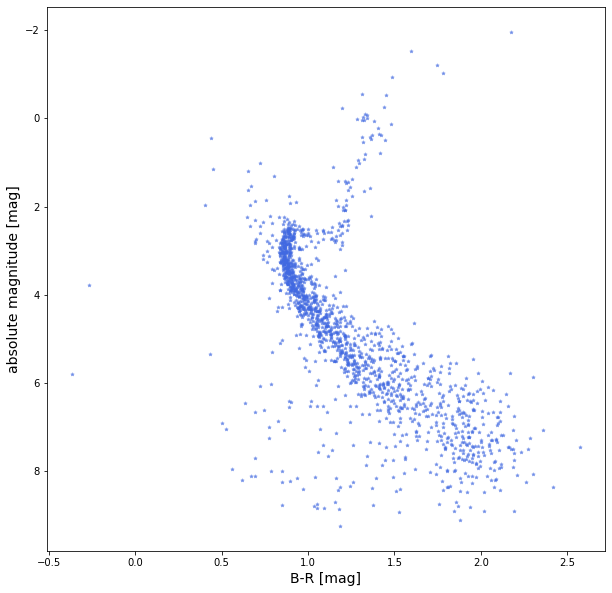

In [106]:
plot_hr(clustered)

In [35]:
from dustmaps.bayestar import BayestarQuery, BayestarWebQuery
# def fetch_extinction(ra: float, dec: float) -> float:

In [33]:
from dustmaps.bayestar import fetch

In [34]:
fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [24]:
clustered.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,label,color,absolute_magnitude
2203,1636148068921376768,Gaia DR3 573545534662757504,573545534662757504,843580694,2016.0,10.732846,0.238209,84.682801,0.235746,0.523439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.160148,8.062476
2211,1636148068921376768,Gaia DR3 573545848194838144,573545848194838144,1131559696,2016.0,10.388068,0.04183,84.720056,0.034255,0.54045,...,0.0749,0.0362,0.1176,0.04,0.0193,0.0628,PHOENIX,2,0.982574,5.047171
2251,1636148068921376768,Gaia DR3 573547630606571648,573547630606571648,1617562041,2016.0,10.891791,0.187793,84.772648,0.170582,0.507045,...,0.0067,0.0016,0.0147,0.0036,0.0008,0.0079,PHOENIX,2,1.116169,5.507987
2282,1636148068921376768,Gaia DR3 573548665696104448,573548665696104448,1076129921,2016.0,9.610934,0.02234,84.824356,0.020948,0.553357,...,0.2076,0.199,0.2155,0.1129,0.1082,0.1173,MARCS,2,0.791554,4.123577
2287,1636148068921376768,Gaia DR3 573548974933750144,573548974933750144,146137968,2016.0,9.880612,0.016126,84.826773,0.014635,0.48882,...,0.2665,0.2468,0.2808,0.1442,0.1336,0.152,PHOENIX,2,0.737464,3.134978


In [37]:
bq = BayestarWebQuery()
bq.query(coords=SkyCoord(ra=10.732846, dec=84.682801, unit=(u.deg, u.deg), distance=0.5*u.kpc), mode='best')

0.029999999329447746

In [42]:
def extinction_coefficient(ra: float, dec: float, distance: float) -> float:
    return bq.query(coords=SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg), distance=distance*u.kpc), mode='best')

Extinction vectors from https://arxiv.org/pdf/1905.02734.pdf for 2MASS:

$J$: 0.7927

$H$: 0.4690

$K_S$: 0.3026

In [38]:
EXTINCTION_VECTOR = {
    'H': 0.4690,
    'J': 0.7927,
    'Ks': 0.3026
}

In [60]:
def extinction_in_passband(reddening_function: float, passband: str) -> float:
    return EXTINCTION_VECTOR[passband]*reddening_function

def gaia_extinction(reddening_function: float) -> float:
    h_ext = extinction_in_passband(reddening_function, 'H')
    ks_ext = extinction_in_passband(reddening_function, 'Ks')
    
    # TODO: add uncert
    # sig = 0.2361
    
    return 0.1836+8.456*(h_ext-ks_ext)-3.781*(h_ext-ks_ext)**2

def gaia_g_extinction(reddening_function: float) -> float:
    h_ext = extinction_in_passband(reddening_function, 'H')
    ks_ext = extinction_in_passband(reddening_function, 'Ks')
    
    # sig = 0.08553
    
    return 0.5594+11.09*(h_ext-ks_ext)+3.040*(h_ext-ks_ext)**2+ks_ext

In [45]:
blue_stragglers = clustered[((clustered.absolute_magnitude<3) & (clustered.color<1.0)) |
                            ((clustered.absolute_magnitude<3.75) & (clustered.color<0.8))]

In [49]:
blue_stragglers['extinction'] = extinction_coefficient(blue_stragglers['ra'].values,
                                                       blue_stragglers['dec'].values,
                                                       1/blue_stragglers['parallax'].values)

/tmp/ipykernel_44530/456296860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blue_stragglers['extinction'] = extinction_coefficient(blue_stragglers['ra'].values,


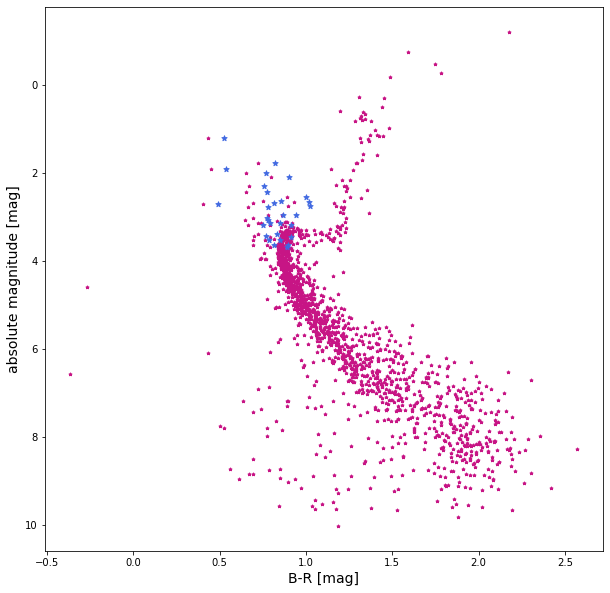

In [50]:
plot_hr(clustered)
plt.scatter(blue_stragglers.color+blue_stragglers.extinction, blue_stragglers.absolute_magnitude,
            s=30., color='royalblue', marker='*');

In [24]:
data = Table()
data['_x'] = sources_normalized[:, 0]
data['_y'] = sources_normalized[:, 1]
data['Plx'] = sources_normalized[:, 2]
data['pmRA'] = sources_normalized[:, 3]
data['pmDE'] = sources_normalized[:, 4]
ascii.write(data, 'pyUPMASK/input/ngc_188.dat', overwrite=True) 

# pyUPMASK

In [25]:
pyupmask_clustered = ascii.read('pyUPMASK/output/ngc_188.dat').to_pandas()

In [26]:
len(pyupmask_clustered[pyupmask_clustered.probs_final>0.9])

1528

In [27]:
CLUSTER_THRESHOLD: float = 0.75
labels_pyupmask = (pyupmask_clustered.probs_final>CLUSTER_THRESHOLD).astype(int).values-1
    
labelled_sources_pyupmask = label_sources(sources_to_cluster,
                                          labels_pyupmask)
clustered_pyupmask, noise_pyupmask = get_clustered_and_noise(labelled_sources_pyupmask,
                                                             labels_pyupmask)

r = check_for_cluster_children(cluster_children, clustered_pyupmask)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered_pyupmask)

Clustered: 1908/13684
1327/1624 objects found in the cluster.
Found 450 objects found in the cluster unreported in papers.


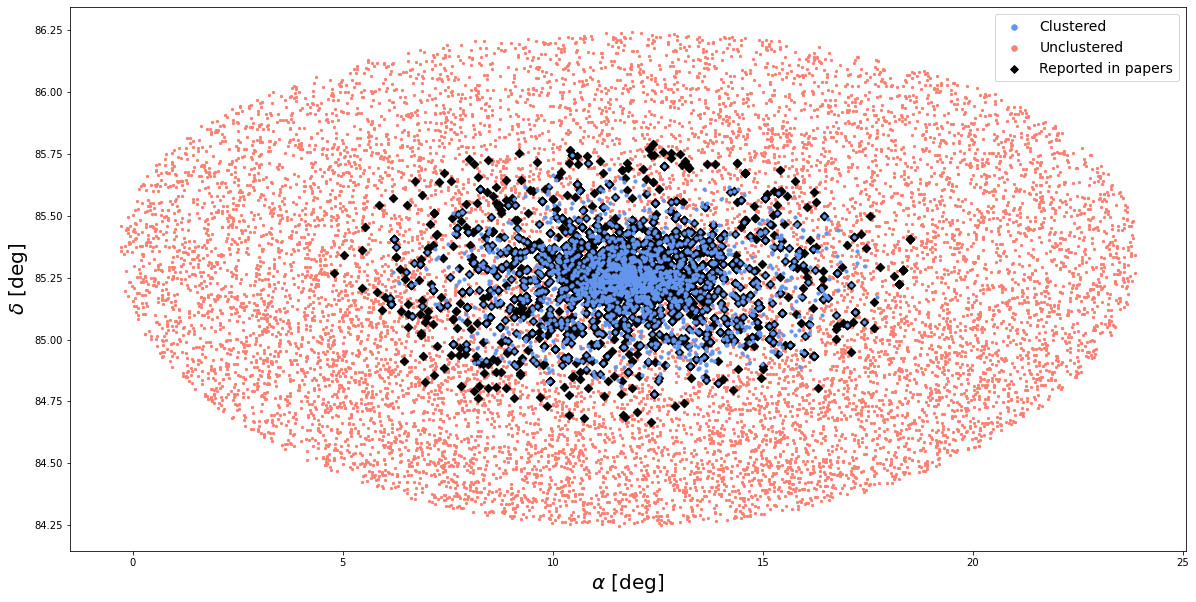

In [28]:
cluster_plot(clustered_pyupmask, noise_pyupmask, cluster_children)

# HDBSCAN

In [29]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, allow_single_cluster=True)

In [30]:
labels_hdbscan = clusterer.fit_predict(sources_normalized)
labelled_sources_hdbscan = label_sources(sources_to_cluster, labels_hdbscan)
clustered_hdbscan, noise_hdbscan = get_clustered_and_noise(labelled_sources_hdbscan, labels_hdbscan)

r = check_for_cluster_children(cluster_children, clustered_hdbscan)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered_hdbscan)

Clustered: 1488/13684
1240/1624 objects found in the cluster.
Found 254 objects found in the cluster unreported in papers.


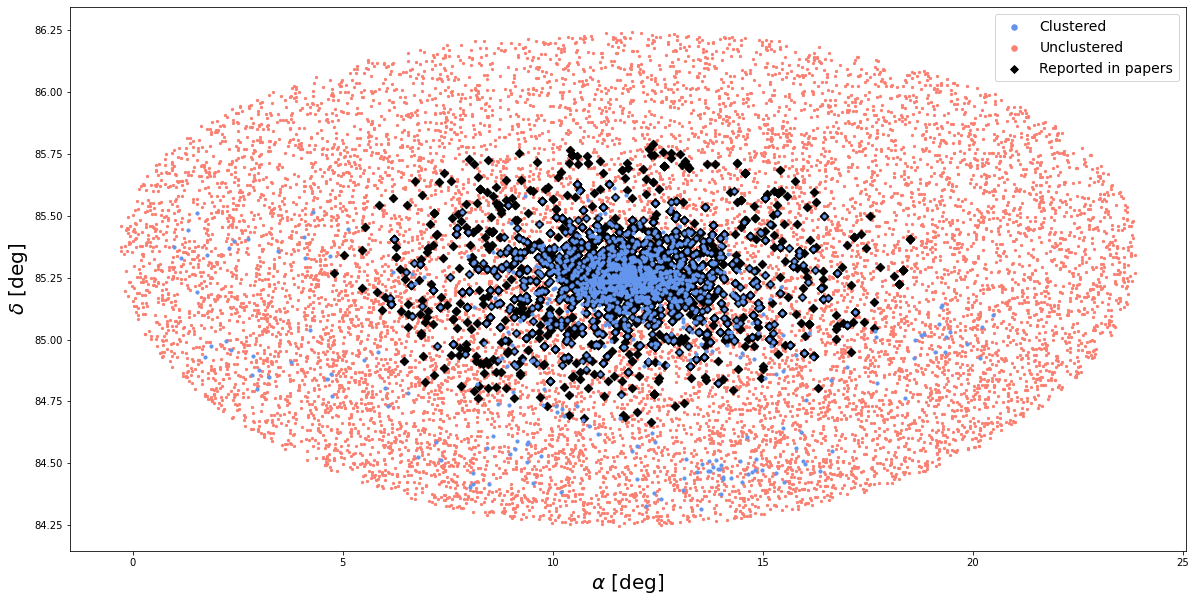

In [31]:
cluster_plot(clustered_hdbscan, noise_hdbscan, cluster_children)